In [ ]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/tapakah68/segmentation-full-body-mads-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  474M  100  474M    0     0  18.1M      0  0:00:26  0:00:26 --:--:-- 19.6M


In [ ]:
!unzip archive.zip

# Body Segmentation

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In video production, for example, in weather forecasts, we often need to cut out a human image from camera and place it on top of some other footage. This is typically done using **chroma key** techniques, when a human is filmed in front of a uniform color background, which is then removed. In this lab, we will train a neural network model to cut out the human silhouette.

We will be using [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset) from Kaggle. Download the dataset manually from Kaggle and unzip in into current directory.

In [ ]:
!ls

archive.zip  segmentation_full_body_mads_dataset_1192_img
df.csv	     segmentation_full_body_mads_dataset_1192_img_folder
sample_data


In [ ]:
dataset_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'

import os
import matplotlib.pyplot as plt

Let's see how images in the dataset look like:

In [ ]:
img_path = os.path.join(dataset_path,'images')
mask_path = os.path.join(dataset_path,'masks')

fnames = os.listdir(img_path)

def load_image(img_name):
    img = plt.imread(os.path.join(img_path,img_name))
    mask = plt.imread(os.path.join(mask_path,img_name))
    return img,mask

(-0.5, 511.5, 383.5, -0.5)

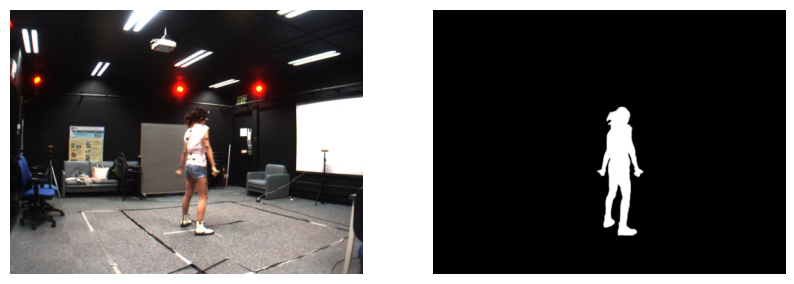

In [ ]:
img, mask = load_image(fnames[5])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

In [ ]:
from torch.utils.data.dataset import Dataset
import torch

class ImageDataset(Dataset):
    """
    """

    def __init__(self, ids_file=None, transforms=None):
        self.transforms = transforms
        self.ids_file = ids_file

    def __len__(self):
        return len(self.ids_file)

    def __getitem__(self, idx):
        img_file = self.ids_file[idx]
        img, mask = load_image(img_file)

        # apply the transform to the image (random cropping)
        # if self.transforms is not None:
        #     img, mask = self.transforms(img, mask)

        return torch.from_numpy(img) , torch.from_numpy(mask[:,:,0:1])


In [ ]:
# divide dataset

from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(len(fnames)))

In [ ]:
len(train_ids), len(test_ids)

train_dataset = ImageDataset([fnames[i] for i in train_ids])
test_dataset = ImageDataset([fnames[i] for i in test_ids])


from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
len(train_dataset), len(test_dataset)

(894, 298)

In [ ]:
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)

        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [ ]:
net = UNet()

net(torch.randn(1, 3, 16, 16)).shape

torch.Size([1, 1, 16, 16])

In [ ]:
!pip install pytorch-lightning

In [ ]:
# trainer class
import pytorch_lightning as pl
class MyNetPL(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_nb): # calculation of training loss from batch of data
        x, y = batch # x: (b, 4) y: (b) y: integer (b, h, w, d) => (b, d, h, w)
        loss = torch.nn.BCELoss()(self.forward(x.permute(0, 3, 1, 2)), y.permute(0, 3, 1, 2))
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr = 0.005)
        return optimizer

    def validation_step(self, batch, batch_nb): # calculate loss, accuracy in validation step
        x, y = batch # x: (b, 4) y: (b)
        val_loss = torch.nn.BCELoss()(self.forward(x.permute(0, 3, 1, 2)), y.permute(0, 3, 1, 2))
        self.log('val_loss', val_loss, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_nb): # calculate loss, accuracy in validation step
        x, y = batch # x: (b, 4) y: (b)
        test_loss = torch.nn.BCELoss()(self.forward(x.permute(0, 3, 1, 2)), y.permute(0, 3, 1, 2))
        self.log('test_loss', test_loss, on_step=True, on_epoch=True)

In [ ]:
import wandb
wandb.init(project='pt-lightning-segmentation', name='u-net')


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
net = MyNetPL()
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
trainer = pl.Trainer(max_epochs = 20, logger=pl.loggers.WandbLogger(),
                     check_val_every_n_epoch=1,
                     log_every_n_steps = 1, accelerator='gpu', callbacks=[
                                                                                                      ModelCheckpoint(filename='best_model_{val_loss}', monitor='val_loss', mode="min")])
trainer.fit(model = net, train_dataloaders = train_loader, val_dataloaders = test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 974 K  | train
---------------------------------------
974 K     Trainable params
0         Non-trainable params
974 K     Total params
3.898     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
net = MyNetPL.load_from_checkpoint('/content/lightning_logs/xkvukua8/checkpoints/best_model_val_loss=0.2521679401397705.ckpt')


In [ ]:
output = net(train_dataset[0][0].cuda().unsqueeze(0).permute(0, 3, 1, 2))
output = (output > 0.5).float()
# output.cpu().numpy()

(-0.5, 511.5, 383.5, -0.5)

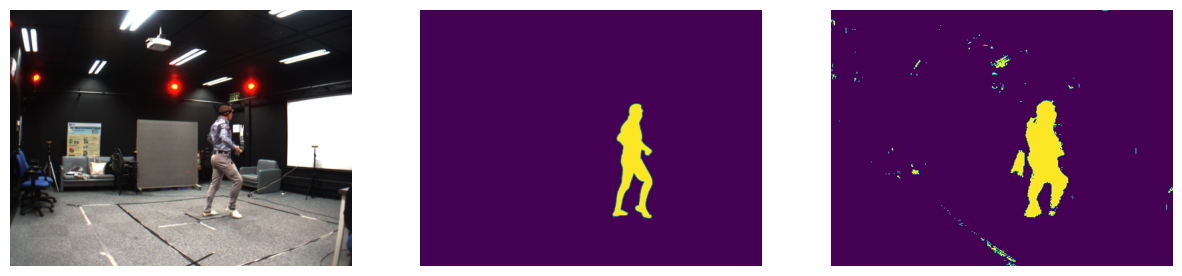

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(train_dataset[0][0].numpy())
ax[1].imshow(train_dataset[0][1].numpy())
ax[2].imshow(output.detach().cpu().squeeze().numpy())
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')